In [1]:
import jax.numpy as jnp
import jax.ops
import scipy as scipy
import scipy.integrate
import scipy.optimize
from jax import jit
from functools import partial
import numpy as np
from jax.experimental.ode import odeint
from ticktack import load_presaved_model, Box, Flow, CarbonBoxModel
import numpy as np
from ticktack import fitting
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
from jax.lax import cond, dynamic_update_slice, fori_loop, dynamic_slice, sub
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
from scipy.interpolate import interp1d

In [3]:
sf.time_data.shape

(984,)

In [4]:
sf = fitting.SingleFitter('Guttler15', 'Guttler15')
sf.load_data("data/ETH.csv")
f = interp1d(sf.time_data, sf.d14c_data)
f2 = interp1d(sf.time_data, sf.d14c_data_error)
sf.time_data = sf.annual
sf.d14c_data = f(sf.time_data)
sf.d14c_data_error = f2(sf.time_data)
chain = sf.MC_reconstruct(iters=300)

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [09:00<00:00,  1.80s/it]


In [5]:
sf.d14c_data.size, sf.annual.size

(984, 984)

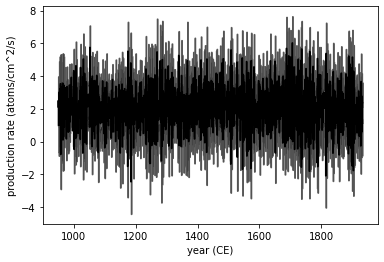

In [6]:
fig, ax = plt.subplots()
mean = np.mean(chain, axis=0)
std = np.std(chain, axis=0)
ax.errorbar(sf.time_data,mean, color='black', drawstyle="steps")
ax.fill_between(sf.time_data, mean-std, mean+std,step='pre', alpha=0.6,facecolor=(0,0,0,.1),edgecolor=(0,0,0,0.8), lw=1.5)
plt.xlabel("year (CE)")
plt.ylabel("production rate (atoms/cm^2/s)")
plt.show()

In [7]:
def tt(time, aa):
    return jnp.interp(time,sf.time_data,aa)

sf.compile_production_model(tt)

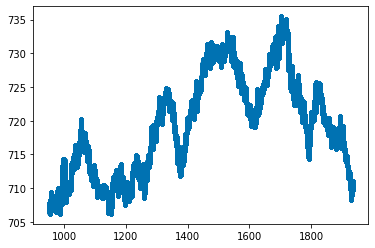

In [8]:
event = sf.run_event(y0=sf.steady_state_y0, params=(mean,))
time_values = jnp.linspace(jnp.min(sf.annual), jnp.max(sf.annual) + 2, (sf.annual.size + 1) * sf.oversample)
plt.plot(time_values, event[:,1], ".")

binned_data = sf.cbm.bin_data(event[:, sf.box_idx], sf.oversample, sf.annual, growth=sf.growth)
gaga = (binned_data - sf.steady_state_y0[sf.box_idx]) / sf.steady_state_y0[sf.box_idx] * 1000

(950.0, 1200.0)

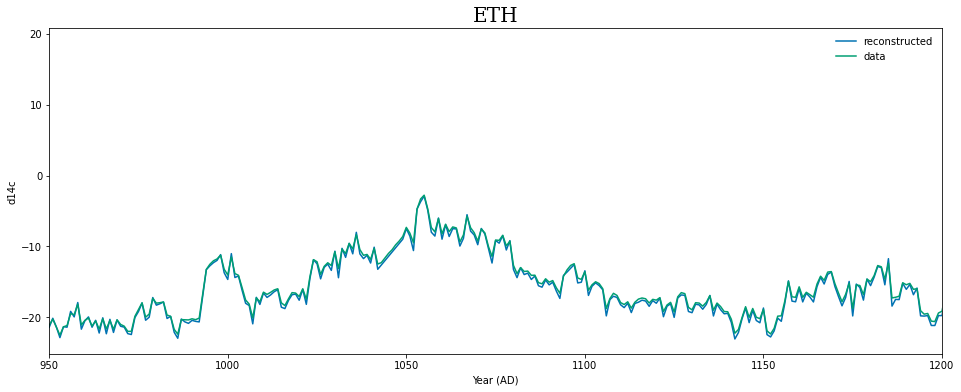

In [12]:
fig, ax = plt.subplots(figsize=(16, 6))
# ax.errorbar(sf.time_data,gaga+sf.offset, fmt='o')
# ax.plot(sf.time_data, sf.d14c_data, 'o')

ax.plot(sf.time_data, sf.d14c_data)
ax.plot(sf.annual, gaga+sf.offset)
ax.legend(['reconstructed', 'data'], frameon=False)
ax.set_title("ETH", fontfamily="serif", fontsize=20)
ax.set_ylabel("d14c");
ax.set_xlabel("Year (AD)");
ax.set_xlim(950, 1200)
# fig.savefig("ETH.jpg")
# ax.set_xlim(1600, 1800)